In [1]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader

In [2]:
# datasets: 'digits', 'fashion'
dataset = 'digits'

In [3]:
if dataset == 'digits':
    data = torchvision.datasets.MNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = torchvision.datasets.MNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )
    labels_map = {
        0: "0",
        1: "1",
        2: "2",
        3: "3",
        4: "4",
        5: "5",
        6: "6",
        7: "7",
        8: "8",
        9: "9",
    }
elif dataset == 'fashion':
    data = torchvision.datasets.FashionMNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = torchvision.datasets.FashionMNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }

1
3
2
4
2
2
1
9
8


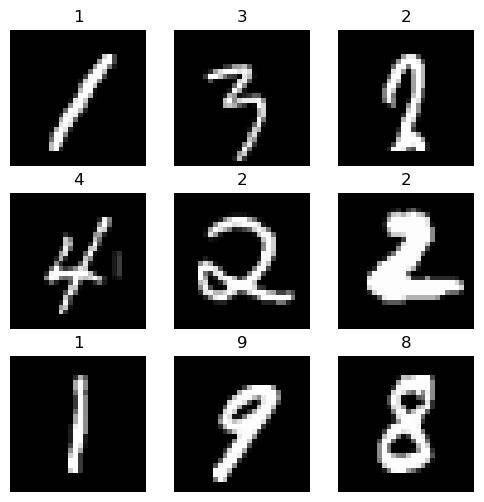

In [4]:
figure = plt.figure(figsize=(6,6))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_index = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_index]
    print(label)
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(labels_map[label])
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [28]:
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [48]:
class VarAutoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        self.linear1 = nn.Linear(20, 10)
        self.linear2 = nn.Linear(20, 10)
        self.G = torch.distributions.Normal(0, 1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + std*self.G.sample(mu.shape)

    def condition_on_label(self, z, y):
        o_h = nn.functional.one_hot(y, num_classes=10)
        return z + o_h

    def forward(self, x, y):
        x = self.encoder(x)
        mu = self.linear1(x)
        logvar = self.linear2(x)
        z = self.reparametrize(mu, logvar)
        output = self.decoder(self.condition_on_label(z, y))
        return output, mu, logvar

VAE = VarAutoencoder()

In [49]:
learning_rate = 1e-4
batch_size = 32

In [50]:
loss_1 = nn.MSELoss()

In [51]:
def loss_2(mu, logvar):
    return torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar), dim = 1), dim = 0).sum()

In [52]:
#optimizer = torch.optim.SGD(ae.parameters(), lr=learning_rate, momentum=momentum)
optimizer = torch.optim.Adam(VAE.parameters(),
                             lr = learning_rate,
                             weight_decay = 1e-8)
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

Epoch  0
loss1 tensor(0.2310) loss2 tensor(0.1289)
[13 18 26 11]


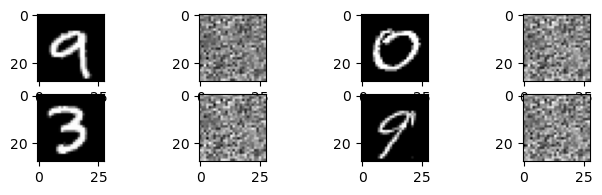

2.3100152015686035
Epoch  1
loss1 tensor(0.0633) loss2 tensor(4.9079)
[24 31 31 26]


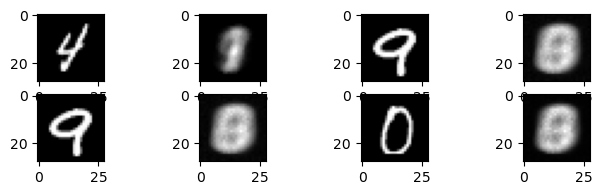

0.6380746364593506


KeyboardInterrupt: 

In [53]:
# Training loop
epochs = 30
losses = []
beta1 = 10
beta2 = 0.001
for epoch in range(epochs):
    plot = True

    VAE.train()
    for (image, label) in data_loader:

        # Reshape image for input
        image = image.reshape(-1, 784)
        # Feed through the network
        reconstruction, mu, logvar = VAE(image, label)
        # Calculate loss function
        loss = beta1*loss_1(reconstruction, image) + beta2*loss_2(mu, logvar)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if plot==True:
            fig = plt.figure(figsize=(8,4))
            print('Epoch ', epoch)
            with torch.no_grad():
                print('loss1', loss_1(reconstruction, image), 'loss2', loss_2(mu, logvar))
                recon_plot = reconstruction.reshape(-1, 28, 28)
                images_plot = image.reshape(-1, 28, 28)
                indices = numpy.random.choice(32, 4)
                print(indices)
                for i, ind in enumerate(indices):
                    ax1 = fig.add_subplot(4,4,2*i+1)
                    ax1.imshow(images_plot[ind], cmap='gray')
                    ax2 = fig.add_subplot(4,4,2*i+2)
                    ax2.imshow(recon_plot[ind], cmap='gray')
            
            plt.show()
            print(losses[-1])
            plot=False

        

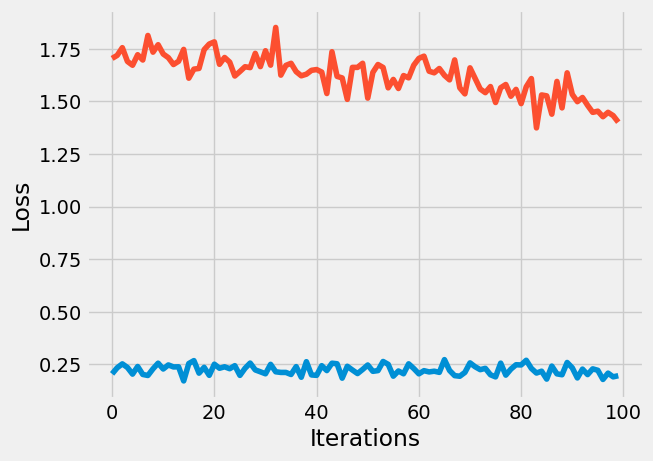

In [20]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(losses[-100:])
plt.plot(losses[:100])

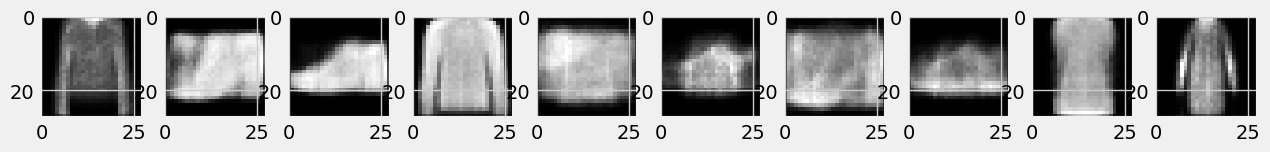

In [24]:
# Decoding randomly generated latent space points

sample_index = numpy.random.randint(len(data))
img, label = data[sample_index]
fig = plt.figure(figsize=(14,10))
with torch.no_grad():
    for i in range(10):
        z = VAE.encoder(img.reshape(-1, 784))
        z = VAE.linear1(z)
        #print(z)
        z_rand = torch.distributions.Normal(0,1).sample(z.shape)
        x_rand = VAE.decoder(z_rand)
        ax = fig.add_subplot(1,10,i+1)
        ax.imshow(x_rand.squeeze().reshape(28,28), cmap='grey')
plt.show()